<a href="https://colab.research.google.com/github/Magferat/Clustering-with-Neural-Networks/blob/main/Aoutoencoder_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]


In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class Autoencoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),  # --> [B, 64, 7, 7]
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # --> [B, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # --> [B, 1, 28, 28]
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


In [ ]:
encoder = ResNetEncoder().to(device)
autoencoder = Autoencoder(encoder).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

print("Training Autoencoder...")
autoencoder.train()
for epoch in range(103):
    total_loss = 0
    loop = tqdm(data_loader, desc=f"Epoch {epoch+1}")
    for imgs, _ in loop:
        imgs = imgs.to(device)
        recon = autoencoder(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=total_loss / len(data_loader))


Training Autoencoder...


Epoch 70: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s, loss=0.0902]


In [ ]:
print("Extracting embeddings...")
autoencoder.eval()
all_embeddings, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(data_loader, desc="Embedding"):
        imgs = imgs.to(device)
        z = encoder(imgs)
        all_embeddings.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

embeddings = np.concatenate(all_embeddings)
labels = np.concatenate(all_labels)

embeddings = StandardScaler().fit_transform(embeddings)


Extracting embeddings...


Embedding: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]


Silhouette Score: 0.16922909
Davies-Bouldin Index: 1.9801714358782205
Calinski-Harabasz Index: 5312.0005


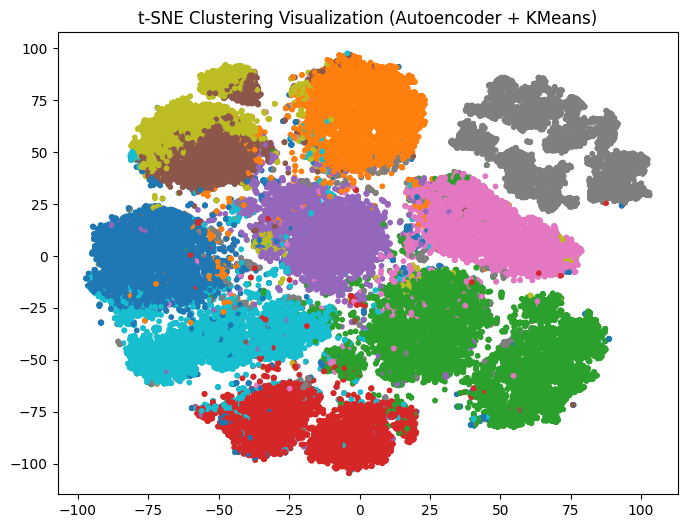

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
preds = kmeans.fit_predict(embeddings)

print("Silhouette Score:", silhouette_score(embeddings, preds))
print("Davies-Bouldin Index:", davies_bouldin_score(embeddings, preds))
print("Calinski-Harabasz Index:", calinski_harabasz_score(embeddings, preds))

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=preds, cmap='tab10', s=10)
plt.title("t-SNE Clustering Visualization (Autoencoder + KMeans)")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
from google.colab import files

# Calculate metrics
sil_score = silhouette_score(embeddings, preds)
dbi_score = davies_bouldin_score(embeddings, preds)
ch_score = calinski_harabasz_score(embeddings, preds)

# Print nicely
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

# # Save to CSV
# results = pd.DataFrame([{
#     "Model": "Autoencoder + KMeans",
#     "Silhouette": sil_score,
#     "Davies-Bouldin": dbi_score,
#     "Calinski-Harabasz": ch_score
# }])
# results.to_csv("clustering_results.csv", index=False)

# # Download the CSV file
# files.download("clustering_results.csv")


Silhouette Score: 0.1692
Davies-Bouldin Index: 1.9802
Calinski-Harabasz Index: 5312.0005


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

with open("kmeans_outputs.pkl", "wb") as f:
    pickle.dump({"embeddings": embeddings, "labels": preds}, f)


In [ ]:
with open("kmeans_outputs.pkl", "rb") as f:
    data = pickle.load(f)

embeddings = data["embeddings"]
preds = data["labels"]
